# Description

This notebook answers: **how LGBM deals with missing values?** What does the algorithm do when there are missing values on the training dataset and on prediction time? 

To achieve this I tested the following scenarios: 
- if the missing values are on training data or only on prediction time
- if, on training data, the NaN values reduce the loss or no
- LGBMClassifier x LGBMRegressor

The conclusion:

>LGBM uses the NaN values as any other value, trying to use it on the tree if it reduces the loss.
>When the NaN values aren't on the training dataset, the prediction for those values will be the same as the one of the leftmost leaves (default path)


# Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.special import expit
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

# Functions

In [3]:
def train_and_evaluate(df, lgbm_params, n_trees_to_plot=1, table_tree_index_to_display=None, cols_table_tree_to_filter=None):
    model = lgb.LGBMClassifier(**lgbm_params)
    model.fit(df[["X"]],df[["y"]])
    
    df["y_pred"] = model.predict(df[["X"]])
    df["y_pred_proba"] = model.predict_proba(df[["X"]])[:, 1]
    print(f'Accuracy is: {accuracy_score(df["y"], df["y_pred"])}')
    display(
        df\
        .groupby(["X", "y"], dropna=False)\
        .agg(y_pred=('y_pred', 'mean'), y_pred_proba=('y_pred_proba', 'mean'), count=('y_pred', 'count'))\
        .reset_index()
    )

    table_tree = model.booster_.trees_to_dataframe()

    if table_tree_index_to_display is not None:
        table_tree = table_tree\
            .query("tree_index == @table_tree_index_to_display")
    if cols_table_tree_to_filter is not None:
        table_tree = table_tree[cols_table_tree_to_filter]
    display(table_tree)

    n_trees_to_plot = model.booster_.num_trees() if n_trees_to_plot is None else n_trees_to_plot
    iterations = min(n_trees_to_plot, model.booster_.num_trees())
    for tree_index in range(0, n_trees_to_plot):
        display(lgb.plot_tree(model, example_case=pd.DataFrame([{"X": np.NaN}]), show_info="data_percentage", tree_index=tree_index))
    return model

def predict_and_evaluate_classifier(df, features, y_col, model):
    df["y_pred"] = model.predict(df[features])
    df["y_pred_proba"] = model.predict_proba(df[features])[:, 1]
    print(f'Accuracy is: {accuracy_score(df[y_col], df["y_pred"])}')
    return df\
        .groupby(features + [y_col], dropna=False)\
        .agg(y_pred=('y_pred', 'mean'), y_pred_proba=('y_pred_proba', 'mean'), count=('y_pred', 'count'))\
        .reset_index()

def predict_and_evaluate_regressor(df, features, y_col, model):
    df["y_pred"] = model.predict(df[features])
    print(f'RMSe is: {mean_squared_error(df[y_col], df["y_pred"], squared=False)}')
    return df\
        .groupby(features + [y_col], dropna=False)\
        .agg(y_pred=('y_pred', 'mean'), count=('y_pred', 'count'))\
        .reset_index()
    
def trees_to_dataframe(df, tree_indexes_to_filter=None, cols_to_filter=["node_depth", "node_index", "split_gain", "threshold", "decision_type", "missing_direction", "value","count"]):
    table_tree = model.booster_.trees_to_dataframe()

    if tree_indexes_to_filter is not None:
        table_tree = table_tree\
            .query("tree_index == @tree_indexes_to_filter")
    if cols_to_filter is not None:
        table_tree = table_tree[cols_to_filter]
    return table_tree

def plot_tree_on_diagram(model, n_trees_to_plot=1):
    n_trees_to_plot = model.booster_.num_trees() if n_trees_to_plot is None else n_trees_to_plot
    iterations = min(n_trees_to_plot, model.booster_.num_trees())
    for tree_index in range(0, n_trees_to_plot):
        display(lgb.plot_tree(model, example_case=pd.DataFrame([{"X": np.NaN}]), show_info="data_percentage", tree_index=tree_index))
    return model

def train_lgbm_model(x, y, lgbm_class, lgbm_params):
    model = lgbm_class(**lgbm_params)
    model.fit(x, y)
    return model
    
def predict_missing_value(model):
    test_df = pd.DataFrame([{"X": np.NaN}])
    test_df["y_pred"] = model.predict(test_df[["X"]])
    return test_df

def plot_interactive_tree(model, tree_index=None):
    if tree_index is None:
        tree_index=model.booster_.num_trees() - 1
    try:
        # To enable interactive mode you should install ipywidgets
        # https://github.com/jupyter-widgets/ipywidgets
        from ipywidgets import interact, SelectMultiple
        INTERACTIVE = True
    except ImportError:
        INTERACTIVE = False
    
    def render_tree(tree_index, show_info, precision=3):
        show_info = None if 'None' in show_info else show_info
        return lgb.create_tree_digraph(model, tree_index=tree_index,
                                       show_info=show_info, precision=precision)

    
    if INTERACTIVE:
        # create widget to switch between trees and control info in nodes
        interact(render_tree,
                 tree_index=(0, tree_index),
                 show_info=SelectMultiple(  # allow multiple values to be selected
                     options=['None',
                              'split_gain',
                              'internal_value',
                              'internal_count',
                              'internal_weight',
                              'leaf_count',
                              'leaf_weight',
                              'data_percentage'],
                     value=['None']),
                 precision=(0, 10))
        tree = None
    else:
        tree = render_tree(tree_index, ['None'])
    return tree

# LGBM Classifier

## NaN on training dataset

### NaN reduce loss

Accuracy is: 1.0


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,X,y,y_pred,y_pred_proba,count
0,1.0,0,0.0,0.000015,333
1,2.0,0,0.0,0.000015,333
2,NaN,1,1.0,0.999971,333


,node_depth,node_index,split_gain,threshold,decision_type,missing_direction,value,count
0,1,0-S0,999.0,1.000000e-35,<=,left,-0.693147,999
1,2,0-L0,NaN,NaN,None,None,-0.393147,333
2,2,0-L1,NaN,NaN,None,None,-0.843147,666


<Axes: >

LGBMClassifier(verbose=-1)

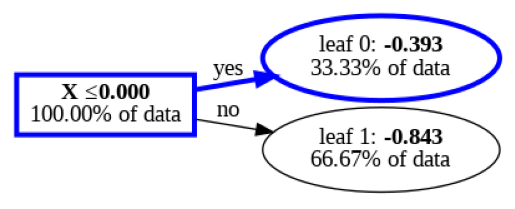

In [5]:
N = 1000
df = pd.DataFrame({
    'X': np.repeat([1, 2, np.NaN], N / 3),
    'y': np.repeat([0, 0, 1], N / 3)

})
lgbm_params = {"verbose": -1}

model = train_lgbm_model(df[["X"]],df[["y"]], lgb.LGBMClassifier, lgbm_params)
display(predict_and_evaluate_classifier(df, ["X"], "y", model))
display(trees_to_dataframe(df, tree_indexes_to_filter=[0]))
plot_tree_on_diagram(model, n_trees_to_plot=1)

### NaN don't reduce loss

Accuracy is: 0.75


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,X,y,y_pred,y_pred_proba,count
0,0.0,1,1.0,0.995183,250
1,1.0,0,0.0,0.004817,250
2,NaN,0,1.0,0.500003,250
3,NaN,1,1.0,0.500003,250


,node_depth,node_index,split_gain,threshold,decision_type,missing_direction,value,count
0,1,0-S0,333.333008,1.000000e-35,<=,left,0.000000,1000
1,2,0-S1,166.667007,1.000000e-35,<=,right,0.066667,750
2,3,0-L0,NaN,NaN,None,None,0.200000,250
3,3,0-L2,NaN,NaN,None,None,0.000000,500
4,2,0-L1,NaN,NaN,None,None,-0.200000,250


<Axes: >

LGBMClassifier(verbose=-1)

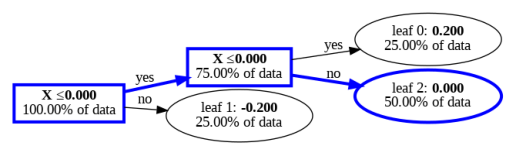

In [6]:
N = 1000
df = pd.DataFrame({
    'X': np.repeat([0, 1, np.NaN, np.NaN], N / 4),
    'y': np.repeat([1, 0, 0, 1], N / 4)

})
lgbm_params={'verbose': -1}

model = train_lgbm_model(df[["X"]],df[["y"]], lgb.LGBMClassifier, lgbm_params)
display(predict_and_evaluate_classifier(df, ["X"], "y", model))
display(trees_to_dataframe(df, tree_indexes_to_filter=[0]))
plot_tree_on_diagram(model, n_trees_to_plot=1)

Accuracy is: 0.75


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,X,y,y_pred,y_pred_proba,count
0,0.0,0,0.0,0.365834,250
1,1.0,1,1.0,0.634166,250
2,NaN,0,0.0,0.500000,250
3,NaN,1,0.0,0.500000,250


,node_depth,node_index,split_gain,threshold,decision_type,missing_direction,value,count
0,1,0-S0,333.333008,1.000000e-35,<=,left,0.000000,1000
1,2,0-S1,166.667007,1.000000e-35,<=,right,-0.066667,750
2,3,0-L0,NaN,NaN,None,None,-0.200000,250
3,3,0-L2,NaN,NaN,None,None,0.000000,500
4,2,0-L1,NaN,NaN,None,None,0.200000,250


<Axes: >

LGBMClassifier(n_estimators=3, verbose=-1)

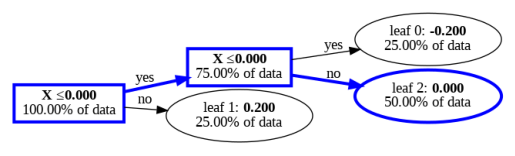

In [7]:
N = 1000
df = pd.DataFrame({
    'X': np.repeat([0,1 , np.NaN, np.NaN], N / 4),
    'y': np.repeat([0, 1, 0, 1], N / 4)

})

lgbm_params = {'verbose': -1, 'n_estimators': 3}

model = train_lgbm_model(df[["X"]],df[["y"]], lgb.LGBMClassifier, lgbm_params)
display(predict_and_evaluate_classifier(df, ["X"], "y", model))
display(trees_to_dataframe(df, tree_indexes_to_filter=[0]))
plot_tree_on_diagram(model, n_trees_to_plot=1)

## NaN not on training dataset

Accuracy is: 1.0


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,X,y,y_pred,y_pred_proba,count
0,1,0,0.0,0.365834,500
1,2,1,1.0,0.634166,500


,X,y_pred
0,NaN,0


,node_depth,node_index,split_gain,threshold,decision_type,missing_direction,value,count
0,1,0-S0,1000.0,1.5,<=,left,0.0,1000
1,2,0-L0,NaN,NaN,None,None,-0.2,500
2,2,0-L1,NaN,NaN,None,None,0.2,500


<Axes: >

LGBMClassifier(n_estimators=3, verbose=-1)

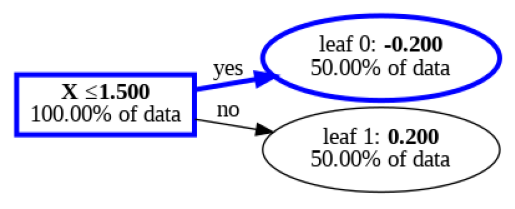

In [9]:
N = 1000
df = pd.DataFrame({
    'X': np.repeat([1, 2], N / 2),
    'y': np.repeat([0, 1], N / 2)

})

model = train_lgbm_model(df[["X"]],df[["y"]], lgb.LGBMClassifier, lgbm_params)
display(predict_and_evaluate_classifier(df, ["X"], "y", model))
display(predict_missing_value(model))
display(trees_to_dataframe(df, tree_indexes_to_filter=[0]))
plot_tree_on_diagram(model, n_trees_to_plot=1)

Accuracy is: 1.0


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,X,y,y_pred,y_pred_proba,count
0,1,1,1.0,0.634166,500
1,2,0,0.0,0.365834,500


,X,y_pred
0,NaN,1


,node_depth,node_index,split_gain,threshold,decision_type,missing_direction,value,count
0,1,0-S0,1000.0,1.5,<=,left,0.0,1000
1,2,0-L0,NaN,NaN,None,None,0.2,500
2,2,0-L1,NaN,NaN,None,None,-0.2,500


<Axes: >

LGBMClassifier(n_estimators=3, verbose=-1)

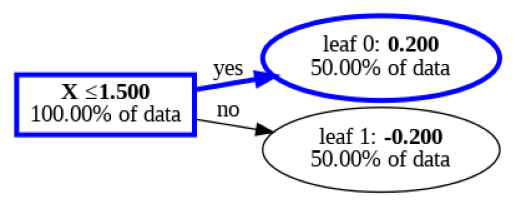

In [10]:
N = 1000
df = pd.DataFrame({
    'X': np.repeat([1, 2], N / 2),
    'y': np.repeat([1, 0], N / 2)

})

model = train_lgbm_model(df[["X"]],df[["y"]], lgb.LGBMClassifier, lgbm_params)
display(predict_and_evaluate_classifier(df, ["X"], "y", model))
display(predict_missing_value(model))
display(trees_to_dataframe(df, tree_indexes_to_filter=[0]))
plot_tree_on_diagram(model, n_trees_to_plot=1)

# Regression

## NaN on training dataset

### NaN reduce loss

RMSe is: 2.1687292025407732e-05


,X,y,y_pred,count
0,1.0,1,1.000027,333
1,3.0,3,2.999973,333
2,NaN,2,2.000000,333


,node_depth,node_index,split_gain,threshold,decision_type,missing_direction,value,count
0,1,0-S0,499.5,2.000000e+00,<=,left,2.00,999
1,2,0-S1,166.5,1.000000e-35,<=,left,1.95,666
2,3,0-L0,NaN,NaN,None,None,2.00,333
3,3,0-L2,NaN,NaN,None,None,1.90,333
4,2,0-L1,NaN,NaN,None,None,2.10,333


<Axes: >

LGBMRegressor(verbose=-1)

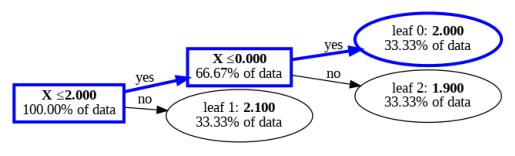

In [11]:
# def train_and_evaluate(df, lgbm_params, n_trees_to_plot=1):
N = 1000
df = pd.DataFrame({
    'X': np.repeat([1, np.NaN, 3], N / 3),
    'y': np.repeat([1, 2, 3], N / 3)

})

lgbm_params = {"verbose": -1}
model = train_lgbm_model(df[["X"]],df[["y"]], lgb.LGBMRegressor, lgbm_params)
display(predict_and_evaluate_regressor(df, ["X"], "y", model))
display(trees_to_dataframe(df, tree_indexes_to_filter=[0]))
plot_tree_on_diagram(model, n_trees_to_plot=1)

### NaN values with low loss reduction

RMSe is: 3.1819805155681027


,X,y,y_pred,count
0,2.0,2,2.000060,250
1,4.0,4,4.000007,250
2,NaN,1,5.499967,250
3,NaN,10,5.499967,250


,node_depth,node_index,split_gain,threshold,decision_type,missing_direction,value,count
0,1,0-S0,1687.5,3.0,<=,right,4.250,1000
1,2,0-L0,NaN,NaN,None,None,4.025,250
2,2,0-S1,375.0,3.0,<=,left,4.325,750
3,3,0-L1,NaN,NaN,None,None,4.375,500
4,3,0-L2,NaN,NaN,None,None,4.225,250


<Axes: >

LGBMRegressor(verbose=-1)

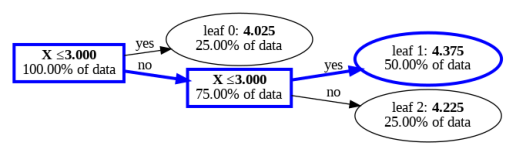

In [12]:
N = 1000
df = pd.DataFrame({
    'X': np.repeat([2, 4, np.NaN, np.NaN], N / 4),
    'y': np.repeat([2, 4, 1, 10], N / 4)

})

lgbm_params = {"verbose": -1}
model = train_lgbm_model(df[["X"]],df[["y"]], lgb.LGBMRegressor, lgbm_params)
display(predict_and_evaluate_regressor(df, ["X"], "y", model))
display(trees_to_dataframe(df, tree_indexes_to_filter=[0]))
plot_tree_on_diagram(model, n_trees_to_plot=1)

## NaN not on training dataset

RMSe is: 1.3280699750817249e-05


,X,y,y_pred,count
0,1,1,1.000013,333
1,2,2,1.999987,333


,X,y_pred
0,NaN,1.000013


,node_depth,node_index,split_gain,threshold,decision_type,missing_direction,value,count
0,1,0-S0,166.5,1.5,<=,left,1.50,666
1,2,0-L0,NaN,NaN,None,None,1.45,333
2,2,0-L1,NaN,NaN,None,None,1.55,333


<Axes: >

LGBMRegressor(verbose=-1)

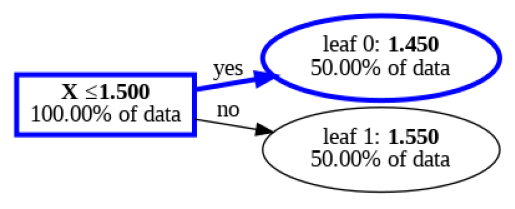

In [13]:
N = 1000
df = pd.DataFrame({
    'X': np.repeat([1, 2], N / 3),
    'y': np.repeat([1, 2], N / 3)

})

lgbm_params = {"verbose": -1,  "n_estimators": 100}


model = train_lgbm_model(df[["X"]],df[["y"]], lgb.LGBMRegressor, lgbm_params)
display(predict_and_evaluate_regressor(df, ["X"], "y", model))
display(predict_missing_value(model))
display(trees_to_dataframe(df, tree_indexes_to_filter=[0]))
plot_tree_on_diagram(model, n_trees_to_plot=1)

RMSe is: 1.3280699750817249e-05


,X,y,y_pred,count
0,1,2,1.999987,333
1,2,1,1.000013,333


,X,y_pred
0,NaN,1.999987


,node_depth,node_index,split_gain,threshold,decision_type,missing_direction,value,count
0,1,0-S0,166.5,1.5,<=,left,1.50,666
1,2,0-L0,NaN,NaN,None,None,1.55,333
2,2,0-L1,NaN,NaN,None,None,1.45,333


<Axes: >

LGBMRegressor(verbose=-1)

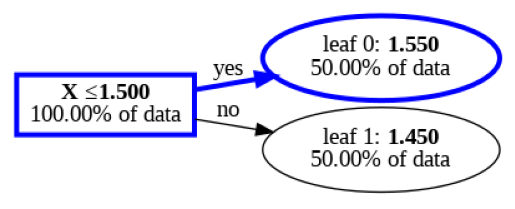

In [14]:
N = 1000
df = pd.DataFrame({
    'X': np.repeat([1, 2], N / 3),
    'y': np.repeat([2, 1], N / 3)

})

lgbm_params = {"verbose": -1,  "n_estimators": 100}


model = train_lgbm_model(df[["X"]],df[["y"]], lgb.LGBMRegressor, lgbm_params)
display(predict_and_evaluate_regressor(df, ["X"], "y", model))
display(predict_missing_value(model))
display(trees_to_dataframe(df, tree_indexes_to_filter=[0]))
plot_tree_on_diagram(model, n_trees_to_plot=1)